In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/DL2021/'  
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

In [4]:
features = [1, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 16]
pollution = 4

train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 12)
(26280,)
(8760, 12)
(8760,)
(35040, 12)
(35040,)
(8760, 12)
(8760,)


In [5]:
SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

In [6]:
def create_dataset_dense(train, test, ahead=3):   # can use this with different 'ahead' values, but default is set to 3
    return train[:-ahead,:], test[ahead:]

X_train_d,r_train_d = create_dataset_dense(train_scaled,train_labels)
X_val_d,r_val_d = create_dataset_dense(val_scaled,val_labels)

In [7]:
def my_Dense(num_features,learning_rate=0.001,hidden=[],ridge_param = 0.0,dropouts=[0.0]):

    model = Sequential()
    model.add(Dropout(dropouts[0], input_shape=(num_features,)))
    for idx in range(len(hidden)):
      model.add(Dense(hidden[idx],activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
      model.add(Dropout(dropouts[idx+1]))
    model.add(Dense(1,activation='linear',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
    
    optim = tf.keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(loss='mae', optimizer=optim, metrics=['mae','mse'])
    return model 

linreg = my_Dense(X_train_d.shape[1],learning_rate=0.001, hidden=[12, 12], ridge_param=0.001, dropouts=[0, 0.05, 0.05])
linreg.summary()
batch_size=64
epochs=30
linreg_history = linreg.fit(X_train_d, r_train_d,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_d, r_val_d),
          shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 325
Trainable params: 325
Non-trainable params: 0
__________________________________________________________

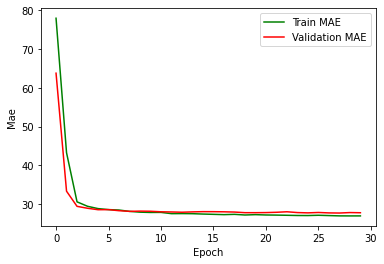

"Current pollution" baseline:
 train mae =  25.365208 
 validation mae =  27.763733


In [8]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

plot_history(linreg_history)

y_train_linreg = linreg.predict(X_train_d)
y_val_linreg = linreg.predict(X_val_d)

mae_train_linreg = mean_absolute_error(r_train_d,y_train_linreg)
mae_val_linreg = mean_absolute_error(r_val_d,y_val_linreg)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_linreg,
      "\n validation mae = ",mae_val_linreg)

In [ ]:
#Initial
#train mae =  26.051659 
#validation mae =  28.148123

#Removed cv_strength feature
#train mae =  26.052532 
#validation mae =  28.147144

#Adding one hidden layer (12 neurons) with l2=0.001, dropout=0.05
#train mae =  25.307522 
#validation mae =  27.613567

#Adding two hidden layers (12, 12 neurons) with l2=0.001, dropout=0.05,0.05
#train mae =  25.158009 
#validation mae =  27.461634


#TESTED:
#Having both dew and temp is better than only having one of them or none of them
#Same for snow and rain